In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import GPyOpt
s = 1


# Data Visualization and Pre-processing

In [2]:
#data = pd.read_csv("/home/oskar/Desktop/fagprojekt/compas/compas-scores-raw.csv")
url = "https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas/compas-scores-raw.csv"
data = pd.read_csv(url)

url = "https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas_propublica/compas-scores-two-years.csv"
new_data = pd.read_csv(url)
# Til at se på dataen 
#print(data.head)
#print(data.columns)

# Check if there are any missing values
print(np.count_nonzero(data["IsDeleted"] == 1))

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")




0
No GPU available.


In [3]:
df = new_data

In [4]:

def is_plot():
    sb.countplot(x = "score_text", hue = "race", data = new_data)
    plt.show()

    sb.countplot(x = "two_year_recid", hue = "race", data = new_data)
    plt.show()
    sb.countplot(x = "is_recid", hue = "race", data = new_data)
    plt.show()
    sb.countplot(x = "is_violent_recid", hue = "race", data = new_data)
    plt.show()

In [5]:
def plots():
    # Show distribution of different ethnicities and sexes
    chart = sb.countplot(x = "Ethnic_Code_Text", data = data)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    chart.set(xlabel='Ethnicity', ylabel='Count')
    plt.show()
    
    chart = sb.countplot(x = "Sex_Code_Text", data = data)
    chart.set(xlabel='Sex', ylabel='Count')
    plt.show()
    
    sb.countplot(x = "Language", data = data)
    plt.show()
    
    # Showing the distribution of the raw and decile values
    plt.xlabel("Raw value")
    plt.ylabel("Frequency")
    plt.title("Visualization of the values")
    plt.hist(data["RawScore"])
    plt.show()
    
    plt.xlabel("Decile value")
    plt.ylabel("Frequency")
    plt.title("Visualization of the decile values")
    plt.hist(data["DecileScore"])
    plt.show()
    
    
    #sb.countplot(x = "RawScore", hue = "Ethnic_Code_Text", data = data)
    #plt.show()
    
    # Indication that some black people might get higher sentences that white people
    sb.countplot(x = "DecileScore", hue = "Ethnic_Code_Text", data = data)
    plt.show()
    
    sb.countplot(x = "ScoreText", hue = "Ethnic_Code_Text", data = data)
    plt.show()

In [6]:
categoricals = ["Agency_Text", "Sex_Code_Text", "Ethnic_Code_Text", "ScaleSet_ID", "AssessmentReason", "Language", "LegalStatus", "CustodyStatus", "MaritalStatus", "RecSupervisionLevel"]
new_categoricals = ["c_charge_degree", "race", "age_cat", "sex", "is_recid", "is_violent_recid", "c_charge_degree"] # "r_charge_degree"    "two_year_recid"
# Changing date of birth into age,as this should work better in a neural network
new_numericals = ["age", "priors_count", "juv_fel_count", "juv_misd_count"] # "days_b_screening_arrest"

if s == 1:
    ages = [None] * len(data["DateOfBirth"])
    for i in range(len(data["DateOfBirth"])):
        ages[i] = 20 +(100 - int(data["DateOfBirth"][i].split("/")[2]))
    data["DateOfBirth"] = ages
    numericals = ["DateOfBirth"]
    s+=1
else:
    pass

outputs = ["ScoreText"]
new_outputs = ["score_text"]

data = data.dropna(axis = 0, how = 'any')
data[outputs] = data[outputs].replace('Low',0)
data[outputs] = data[outputs].replace('Medium',1)
data[outputs] = data[outputs].replace('High',1)
data[outputs] = data[outputs].astype("category")


new_data[new_outputs] = new_data[new_outputs].replace('Low',0)
new_data[new_outputs] = new_data[new_outputs].replace('Medium',1)
new_data[new_outputs] = new_data[new_outputs].replace('High',1)
new_data[new_outputs] = new_data[new_outputs].astype("category")


for category in categoricals:
    data[category] = data[category].astype("category")
    
for new_category in new_categoricals:
    new_data[new_category] = new_data[new_category].astype("category")


In [7]:

# Preparing data for pytorch
Xcat = []
for i in range(len(categoricals)):
    Xcat.append(data[categoricals[i]].cat.codes.values)
Xcat = torch.tensor(Xcat , dtype = torch.int64).T


new_Xcat = []
for i in range(len(new_categoricals)):
    new_Xcat.append(new_data[new_categoricals[i]].cat.codes.values)
new_Xcat = torch.tensor(new_Xcat , dtype = torch.int64).T

#Converting the numerical values to a tensor
Xnum = np.stack([data[col].values for col in numericals], 1)
Xnum = torch.tensor(Xnum, dtype=torch.float)


new_Xnum = np.stack([new_data[col].values for col in new_numericals], 1)
new_Xnum = torch.tensor(new_Xnum, dtype=torch.float)

# Converting the output to tensor
y = torch.tensor(data[outputs].values).flatten()
new_y = torch.tensor(new_data[new_outputs].values).flatten()

# Calculation of embedding sizes for the categorical values in the format (unique categorical values, embedding size (dimension of encoding))
categorical_column_sizes = [len(data[column].cat.categories) for column in categoricals]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]


new_categorical_column_sizes = [len(new_data[column].cat.categories) for column in new_categoricals]
new_categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in new_categorical_column_sizes]

# Train-test split
totalnumber = len(Xnum)
testnumber = int(totalnumber * 0.2)


new_totalnumber = len(new_Xnum)
new_testnumber = int(new_totalnumber * 0.2)

Xcattrain = Xcat[:totalnumber - testnumber]
Xcattest = Xcat[totalnumber - testnumber:totalnumber]
Xnumtrain = Xnum[:totalnumber - testnumber]
Xnumtest = Xnum[totalnumber - testnumber:totalnumber]
ytrain = y[:totalnumber - testnumber]
ytest = y[totalnumber - testnumber:totalnumber]




new_Xcattrain = new_Xcat[:new_totalnumber - new_testnumber]
new_Xcattest = new_Xcat[new_totalnumber - new_testnumber:new_totalnumber]
new_Xnumtrain = new_Xnum[:new_totalnumber - new_testnumber]
new_Xnumtest = new_Xnum[new_totalnumber - new_testnumber:new_totalnumber]
new_ytrain = new_y[:new_totalnumber - new_testnumber]
new_ytest = new_y[new_totalnumber - new_testnumber:new_totalnumber]

# Make sure that we dont validate on training data to compare if the algorithm is biased
df = df[new_totalnumber - new_testnumber:new_totalnumber]
black_data = df[df["race"]=="African-American"]
white_data = df[df["race"]=="Caucasian"]

def normalize(type):
    global new_ytain, new_ytest
    if type == "minmax":
        for i in range(new_Xnumtrain.size()[1]):
            new_Xnumtrain[:,i] = (new_Xnumtrain[:,i]-new_Xnumtrain[:,i].min()) / (new_Xnumtrain[:,i].max()-new_Xnumtrain[:,i].min())
            new_Xnumtest[:,i] = (new_Xnumtest[:,i]-new_Xnumtest[:,i].min()) / (new_Xnumtest[:,i].max()-new_Xnumtest[:,i].min())
        return new_Xnumtrain, new_Xnumtest
    elif type == "zscore":
        for i in range(new_Xnumtrain.size()[1]):
            new_Xnumtrain[:,i] = (new_Xnumtrain[:,i]-new_Xnumtrain[:,i].mean()) / (new_Xnumtrain[:,i].std())
            new_Xnumtest[:,i] = (new_Xnumtest[:,i]-new_Xnumtest[:,i].mean()) / (new_Xnumtest[:,i].std())
        return new_Xnumtrain, new_Xnumtest
    else:
        raise ValueError("Please choose a correct normalization type")
        
normalize("zscore") ;

#new_Xnumtrain = torch.tensor(np.vstack([(new_Xnumtrain[:,i]-new_Xnumtrain[:,i].min()) / (new_Xnumtrain[:,i].max()-new_Xnumtrain[:,i].min()) for i in range(new_Xnumtrain.size()[1]) if "Tue elsker det her"])).view(-1,2)

# Neural Network

In [8]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return nn.functional.softmax(x, dim = -1 )

# Train model on old data

In [146]:
# Define and show the model
#model = Model(categorical_embedding_sizes, 1, 2, [8,16,32,64,128], p=0.6)
model = Model(categorical_embedding_sizes, 1, 2, [10,20,20,10], p=0.6)
if use_cuda:
    model.cuda()
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(2, 1)
    (2): Embedding(9, 5)
    (3): Embedding(2, 1)
    (4): Embedding(1, 1)
    (5): Embedding(2, 1)
    (6): Embedding(5, 3)
    (7): Embedding(6, 3)
    (8): Embedding(7, 4)
    (9): Embedding(4, 2)
  )
  (embedding_dropout): Dropout(p=0.6, inplace=False)
  (batch_norm_num): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=10, out_features=20, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.6, inplace=False)
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): ReLU(inplace=True)
    (10): B

In [147]:
# Loss function and optimization
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001 , weight_decay = 1e-6)

epoch:   1 loss: 0.75206149
epoch:  26 loss: 0.72992122
epoch:  51 loss: 0.71563697
epoch:  76 loss: 0.69822705
epoch: 100 loss: 0.6815894246
[[1999   82]
 [ 786  260]]
              precision    recall  f1-score   support

           0       0.72      0.96      0.82      2081
           1       0.76      0.25      0.37      1046

   micro avg       0.72      0.72      0.72      3127
   macro avg       0.74      0.60      0.60      3127
weighted avg       0.73      0.72      0.67      3127

0.7224176527022705


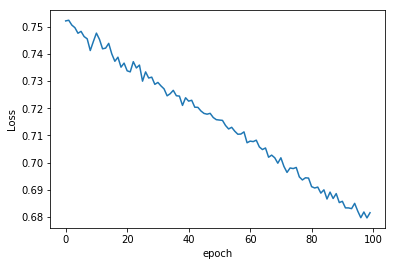

In [148]:
epochs = 100
aggregated_losses = []

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

model.train()
for i in range(epochs):
    i += 1
    y_pred = model(Xcattrain, Xnumtrain)
    single_loss = loss_function(y_pred, ytrain)
    aggregated_losses.append(single_loss)
    
    if i % 25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()
    
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    


# Plot the loss over epocs
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');


# Predict on the test set
model.eval()
with torch.no_grad():
    y_val = model(Xcattest, Xnumtest)
    loss = loss_function(y_val, ytest)


y_val = np.argmax(y_val, axis=1)


print(confusion_matrix(ytest,y_val))
print(classification_report(ytest,y_val))
print(accuracy_score(ytest, y_val))

# Train model on new data

In [10]:
# Define and show the model
model = Model(new_categorical_embedding_sizes, 4, 2, [16,32,64,128,64], p=0.5)
if use_cuda:
    model.cuda()
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(6, 3)
    (2): Embedding(3, 2)
    (3): Embedding(2, 1)
    (4): Embedding(2, 1)
    (5): Embedding(2, 1)
    (6): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=14, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [11]:
# Loss function and optimization
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)

epoch:   1 loss: 0.58529621
epoch:  26 loss: 0.56912929
epoch:  51 loss: 0.56379426
epoch:  76 loss: 0.56587934
epoch: 100 loss: 0.5640946031
[[630 140]
 [225 447]]
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       770
           1       0.76      0.67      0.71       672

   micro avg       0.75      0.75      0.75      1442
   macro avg       0.75      0.74      0.74      1442
weighted avg       0.75      0.75      0.74      1442

0.746879334257975


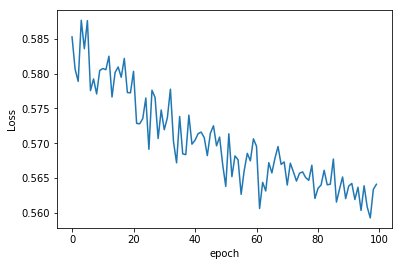

In [14]:
epochs = 100
aggregated_losses = []

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

model.train()
for i in range(epochs):
    i += 1
    y_pred = model(new_Xcattrain, new_Xnumtrain)
    single_loss = loss_function(y_pred, new_ytrain)
    aggregated_losses.append(single_loss)
    
    if i % 25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()
    
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    


# Plot the loss over epocs
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');


# Predict on the test set
model.eval()
with torch.no_grad():
    y_val = model(new_Xcattest, new_Xnumtest)
    loss = loss_function(y_val, new_ytest)


y_val = np.argmax(y_val, axis=1)


print(confusion_matrix(new_ytest,y_val))
print(classification_report(new_ytest,y_val))
print(accuracy_score(new_ytest, y_val))

# Prep black and white

In [15]:
new_categoricals = ["c_charge_degree", "race", "age_cat", "sex", "is_recid", "is_violent_recid", "c_charge_degree"] # "r_charge_degree"    "two_year_recid"
new_numericals = ["age", "priors_count", "juv_fel_count", "juv_misd_count"]
    
for new_category in new_categoricals:
    white_data[new_category] = white_data[new_category].astype("category")
    black_data[new_category] = black_data[new_category].astype("category")

Xcat_white, Xcat_black = [] ,[]
for i in range(len(new_categoricals)):
    Xcat_white.append(white_data[new_categoricals[i]].cat.codes.values)
    Xcat_black.append(black_data[new_categoricals[i]].cat.codes.values)
Xcat_white = torch.tensor(Xcat_white , dtype = torch.int64).T
Xcat_black = torch.tensor(Xcat_black , dtype = torch.int64).T 

Xnum_white = np.stack([white_data[col].values for col in new_numericals], 1)
Xnum_white = torch.tensor(Xnum_white, dtype=torch.float)
Xnum_black = np.stack([black_data[col].values for col in new_numericals], 1)
Xnum_black = torch.tensor(Xnum_black, dtype=torch.float)


def normalize(train,test, type):
    global new_ytain, new_ytest
    if type == "minmax":
        for i in range(train.size()[1]):
            train[:,i] = (train[:,i]-train[:,i].min()) / (train[:,i].max()-train[:,i].min())
            test[:,i] = (test[:,i]-test[:,i].min()) / (test[:,i].max()-test[:,i].min())
        return train , test
    elif type == "zscore":
        for i in range(train.size()[1]):
            train[:,i] = (train[:,i]-train[:,i].mean()) / (train[:,i].std())
            test[:,i] = (test[:,i]-test[:,i].mean()) / (test[:,i].std())
        return train, test
    else:
        raise ValueError("Please choose a correct normalization type")
        
normalize(Xnum_white, Xnum_black, "zscore")
model.eval()
y_val_white = model(Xcat_white, Xnum_white)
y_val_white = np.argmax(y_val_white.detach().numpy(), axis = 1)
y_val_black = model(Xcat_black, Xnum_black)
y_val_black = np.argmax(y_val_black.detach().numpy(), axis = 1)

# Ground truth of recidivism from dataset
y_white = torch.tensor(white_data["two_year_recid"].values).flatten()
y_black = torch.tensor(black_data["two_year_recid"].values).flatten()

print("Confussion matrix for the white:")
conf_white = confusion_matrix( y_white, y_val_white)
print(conf_white)
print(conf_white / conf_white.astype(np.float).sum(axis=1))
print()
print("Confussion matrix for the black:")
conf_black = confusion_matrix( y_black, y_val_black)
print(conf_black)
print(conf_black / conf_black.astype(np.float).sum(axis=1))



Confussion matrix for the white:
[[221  76]
 [ 58 120]]
[[0.74410774 0.42696629]
 [0.1952862  0.6741573 ]]

Confussion matrix for the black:
[[279  70]
 [171 224]]
[[0.79942693 0.17721519]
 [0.48997135 0.56708861]]


# Random Forest

# For the old data

In [66]:
# Define the model and fit it to the data
forestModel = RandomForestClassifier(n_estimators = 53, max_depth = 14, max_features = "log2", criterion = "entropy")
forestModel.fit(Xcattrain, ytrain)

# Predict on the test set
forestPreds = forestModel.predict(Xcattest)
forestProbs = forestModel.predict_proba(Xcattest)[:, 1]

print("Times low scoretext is predicted: ", len(forestPreds[forestPreds == 0]))
print("Times medium scoretext is predicted: ", len(forestPreds[forestPreds == 1]))
print("Times high scoretext is predicted: ", len(forestPreds[forestPreds == 2]))

print("Accuracy of the random forest model: ", len(forestPreds[torch.tensor(forestPreds, dtype = torch.int64) == ytest]) / len(forestPreds))

Times low scoretext is predicted:  1954
Times medium scoretext is predicted:  534
Times high scoretext is predicted:  639
Accuracy of the random forest model:  0.7547169811320755


# For the new data

In [9]:
# Define the model and fit it to the data
forestModel = RandomForestClassifier(n_estimators = 53, max_depth = 14, max_features = "log2", criterion = "entropy")
forestModel.fit(new_Xcattrain, new_ytrain)

# Predict on the test set
forestPreds = forestModel.predict(new_Xcattest)

forestProbs = forestModel.predict_proba(new_Xcattest)[:, 1]

print("Predicted no recidivism: ", len(forestPreds[forestPreds == 0]))
print("Predicted recidivism: ", len(forestPreds[forestPreds == 1]))

print("Accuracy of the random forest model: ", len(forestPreds[torch.tensor(forestPreds, dtype = torch.int64) == new_ytest]) / len(forestPreds))

Predicted no recidivism:  799
Predicted recidivism:  643
Accuracy of the random forest model:  0.6692094313453537


# Baysian Optimization

In [ ]:
## define the domain of the considered parameters
n_estimators = tuple(np.arange(1,301,1, dtype= np.int))
# print(n_estimators)
max_depth = tuple(np.arange(1,110,1, dtype= np.int))
# max_features = ('log2', 'sqrt', None)
max_features = (0, 1)
# criterion = ('gini', 'entropy')
criterion = (0, 1)


# define the dictionary for GPyOpt
domain = [{'n_estimators': 'var_1',  'type': 'discrete',     'domain': n_estimators},
          {'max_depth': 'var_2',     'type': 'discrete',     'domain': max_depth},
          {'max_features': 'var_3',  'type': 'categorical',  'domain': max_features},
          {'criterion': 'var_4',     'type': 'categorical',  'domain': criterion}]


## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
def objective_function(x): 
    print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    
    param = x[0]
    
    if param[2] == 0:
        var_3 = "log2"
    else:
        var_3 = "sqrt"
    
    if param[3] == 0:
        var_4 = "gini"
    else:
        var_4 = "entropy"
        
        
#fit the model
    model = RandomForestClassifier(n_estimators = int(param[0]), criterion = var_4, max_depth = int(param[1]), max_features = var_3)
    model.fit(Xcattrain, ytrain)
    forestPreds = model.predict(Xcattest)
    accuracy = len(forestPreds[torch.tensor(forestPreds, dtype = torch.int64) == ytest]) / len(forestPreds)
    return accuracy


opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=.1

opt.run_optimization(max_iter = 100) 


x_best = opt.X[np.argmin(opt.Y)]
print("The best parameters obtained: n_estimators=" + str(x_best[0]) + ", max_depth=" + str(x_best[1]) + ", max_features=" + str(
    x_best[2])  + ", criterion=" + str(
    x_best[3]))

[[290.   2.   0.   1.]]
[[170.  73.   0.   1.]]
[[160.  40.   1.   1.]]
[[27. 62.  0.  0.]]
[[55. 59.  1.  0.]]
[[290.   2.   0.   1.]]
[[289.   2.   0.   1.]]
[[300.  54.   1.   0.]]
[[249.   1.   0.   0.]]
[[265.   1.   1.   0.]]
[[290.   1.   0.   0.]]
[[259.   1.   0.   1.]]
[[232.   1.   1.   1.]]
[[1. 1. 1. 1.]]
[[32.  1.  1.  1.]]
[[17.  1.  1.  0.]]
[[65.  1.  0.  0.]]
[[51.  1.  1.  0.]]
[[289.   1.   1.   1.]]
[[275.   1.   0.   1.]]
[[215.   1.   0.   0.]]
[[225.   1.   0.   0.]]
[[92.  1.  1.  0.]]
[[115.   1.   0.   0.]]
[[103.   1.   0.   0.]]
[[177.   1.   1.   0.]]
[[193.   1.   1.   0.]]
[[146.   1.   1.   0.]]
[[109.   1.   1.   1.]]
[[11.  1.  0.  1.]]
[[1. 1. 0. 0.]]
[[159.   1.   0.   1.]]
[[133.   1.   0.   1.]]
[[82.  1.  0.  1.]]
[[219.   1.   1.   0.]]
[[68.  1.  1.  1.]]
[[184.   1.   0.   1.]]
[[150.   1.   0.   0.]]
[[204.   1.   1.   1.]]
[[290.   1.   0.   1.]]
[[76.  1.  1.  0.]]
[[263.   8.   0.   1.]]
[[108. 109.   0.   0.]]
[[229. 109.   0.   0.]]
[[  